# UNET 구조를 이용한 컬러 복원

<img width="640" alt="U-Net CNN Image Segmentation" src="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png">

Code Reference:
- [keraspp] (https://github.com/jskDr/keraspp)
- https://github.com/4g/unet-color

Implementation Reference:
- https://github.com/phillipi/pix2pix

Theory Reference:
- https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/
- https://arxiv.org/abs/1505.04597


## Import Packages

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import os

import keras
from keras import models, backend
from keras import datasets, utils
from keras.models import Sequential, load_model
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D,\
                    BatchNormalization, Concatenate, Activation
    
from sklearn.preprocessing import minmax_scale

backend.set_image_data_format('channels_first')

## Prepare Data

In [7]:
class DATA():
    def __init__(self, in_ch=None):
        (x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()
        if x_train.ndim == 4:
            if backend.image_data_format() == 'channels_first':
                n_ch, img_rows, img_cols = x_train.shape[1:]
            else:
                img_rows, img_cols, n_ch = x_train.shape[1:]
        else:
            img_rows, img_cols = x_train.shape[1:]
            n_ch = 1
        # in_ch can be 1 for changing BW to color image using UNet
        in_ch = n_ch if in_ch is None else in_ch

        x_train = x_train.astype('float32')
        x_test = x_test.astype('float32')
        x_train /= 255
        x_test /= 255

        def RGB2Gray(X, fmt):
            if fmt == 'channels_first':
                R = X[:, 0:1]
                G = X[:, 1:2]
                B = X[:, 2:3]
            else:  # "channels_last
                R = X[..., 0:1]
                G = X[..., 1:2]
                B = X[..., 2:3]
            return 0.299 * R + 0.587 * G + 0.114 * B
        
        def RGB2RG(x_train_out, x_test_out, fmt):
            if fmt == 'channels_first':
                x_train_in = x_train_out[:, :2]
                x_test_in = x_test_out[:, :2]
            else:
                x_train_in = x_train_out[..., :2]
                x_test_in = x_test_out[..., :2]      
            return x_train_in, x_test_in
        
        if backend.image_data_format() == 'channels_first':
            x_train_out = x_train.reshape(x_train.shape[0], n_ch, img_rows, img_cols)
            x_test_out = x_test.reshape(x_test.shape[0], n_ch, img_rows, img_cols)
            input_shape = (in_ch, img_rows, img_cols)
        else:
            x_train_out = x_train.reshape(x_train.shape[0], img_rows, img_cols, n_ch)
            x_test_out = x_test.reshape(x_test.shape[0], img_rows, img_cols, n_ch)
            input_shape = (img_rows, img_cols, in_ch)

        if in_ch == 1 and n_ch == 3:
            x_train_in = RGB2Gray(x_train_out, backend.image_data_format())
            x_test_in = RGB2Gray(x_test_out, backend.image_data_format())
        elif in_ch == 2 and n_ch == 3:
            # print(in_ch, n_ch)
            x_train_in, x_test_in = RGB2RG(x_train_out, x_test_out, backend.image_data_format())
        else:
            x_train_in = x_train_out
            x_test_in = x_test_out

        self.input_shape = input_shape
        self.x_train_in, self.x_train_out = x_train_in, x_train_out
        self.x_test_in, self.x_test_out = x_test_in, x_test_out
        self.n_ch = n_ch
        self.in_ch = in_ch
        
data = DATA(1)
print(data.input_shape, data.x_train_in.shape)
print(data.x_train_out.shape)

(1, 32, 32) (50000, 1, 32, 32)
(50000, 3, 32, 32)


### Visualize

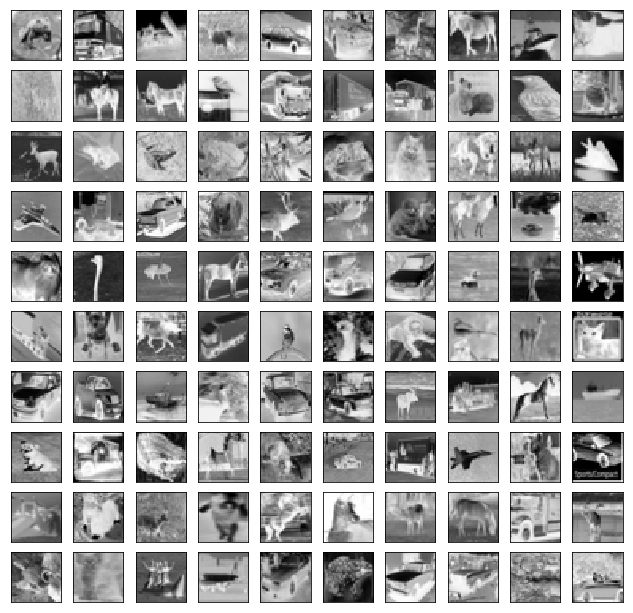

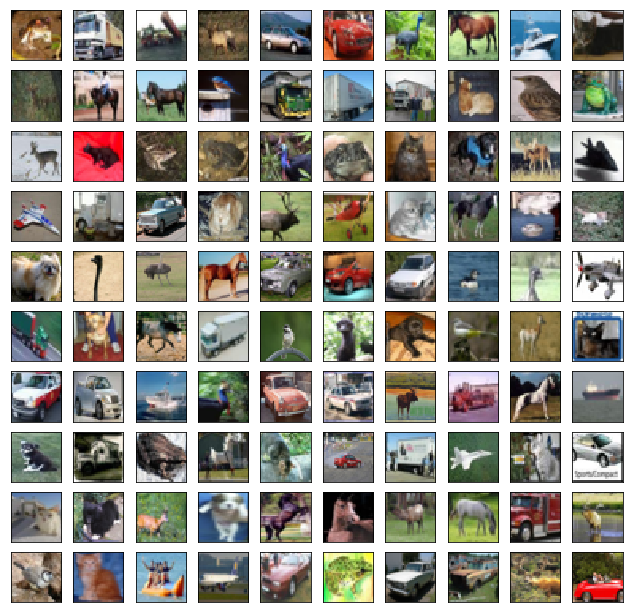

In [8]:
vis_size=100
def draw_image(im, size=100, ncol=10, color=True):
    nrow = (size//10)+1
    fig = plt.figure(figsize=(ncol+1,nrow+1))
    for i in range(size):
        subplot = fig.add_subplot(nrow, ncol, i+1)
        subplot.set_xticks([])
        subplot.set_yticks([])
        if not color: # black and white, im.shape=[i,32,32]
            subplot.imshow(im[i], vmin=0, vmax=1, \
                           cmap=plt.cm.gray_r, interpolation='nearest')
        else: # black and white, im.shape=[i,32,32,3]
            subplot.imshow(im[i], vmin=0, vmax=1)
    #fig.show()
            
draw_image(data.x_train_in[:,0,:,:], color=False)
draw_image(np.transpose(data.x_train_out[:], (0,2,3,1)))

## Model

In [18]:
#######################################################################################
# Convlutional Layer UNET with RGB Cifar10 dataset and Class with Keras Model approach
#######################################################################################

class UNET(models.Model):
    def __init__(self, org_shape, n_ch):
        ic = 3 if backend.image_data_format() == 'channels_last' else 1

        def conv(x, n_f, mp_flag=True):
            x = MaxPooling2D((2, 2), padding='same')(x) if mp_flag else x
            x = Conv2D(n_f, (3, 3), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('tanh')(x)
            x = Dropout(0.05)(x)
            x = Conv2D(n_f, (3, 3), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('tanh')(x)
            return x

        def deconv_unet(x, e, n_f):
            x = UpSampling2D((2, 2))(x)
            x = Concatenate(axis=ic)([x, e])
            x = Conv2D(n_f, (3, 3), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('tanh')(x)
            x = Conv2D(n_f, (3, 3), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('tanh')(x)
            return x

        # Input
        original = Input(shape=org_shape)

        # Encoding
        c1 = conv(original, 16, mp_flag=False)
        c2 = conv(c1, 32)

        # Encoder
        encoded = conv(c2, 64)

        # Decoding
        x = deconv_unet(encoded, c2, 32)
        x = deconv_unet(x, c1, 16)

        decoded = Conv2D(n_ch, (3, 3), activation='sigmoid', padding='same')(x)
        #decoded = Conv2D(n_ch, (3, 3), padding='same')(x)

        super().__init__(original, decoded)
        self.compile(optimizer='adadelta', loss='mse')
        
weight_directory = 'weights'
model_save       = 'cfar10ColorRestoration_weights.h5'

# Check for save directory
if not os.path.exists(weight_directory):
    os.makedirs(weight_directory)
    
# Import previous model if exist. Else, create new model
# To freshly initialize model, delete saved data
full_path = weight_directory + '/' + model_save
unet = UNET(data.input_shape, data.n_ch)
if os.path.isfile(full_path):
    print('Found : Previously trained model. Importing weights...')
    unet.load_weights(full_path)
    #unet = load_model(full_path)
    print('UNET weights imported')
else:
    print('No pre-trained model found. Create new')

print(unet.summary())

Found : Previously trained model. Importing weights...
UNET weights imported
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 1, 32, 32)    0                                            
__________________________________________________________________________________________________
conv2d_23 (Conv2D)              (None, 16, 32, 32)   160         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_21 (BatchNo (None, 16, 32, 32)   128         conv2d_23[0][0]                  
__________________________________________________________________________________________________
activation_21 (Activation)      (None, 16, 32, 32)   0           batch_normalization_21[0][0]     
________________________________

## Training

In [19]:
def plot_loss(history, title):
    if not isinstance(history, dict):
        history = history.history

    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training data', 'Validation data'], loc=0)
    plt.show()

def show_images(data, unet):
    x_test_in = data.x_test_in
    x_test_out = data.x_test_out
    decoded_imgs_org = unet.predict(x_test_in)
    decoded_imgs = decoded_imgs_org

    x_test_out = x_test_out.swapaxes(1, 3).swapaxes(1, 2)    
    decoded_imgs = decoded_imgs.swapaxes(1, 3).swapaxes(1, 2)
    if data.in_ch == 1:
        x_test_in = x_test_in[:, 0, ...]
    elif data.in_ch == 2:
        print(x_test_out.shape)
        x_test_in_tmp = np.zeros_like(x_test_out)
        x_test_in = x_test_in.swapaxes(1, 3).swapaxes(1, 2)
        x_test_in_tmp[..., :2] = x_test_in
        x_test_in = x_test_in_tmp
    else:
        x_test_in = x_test_in.swapaxes(1, 3).swapaxes(1, 2)
    
    n = 10
    plt.figure(figsize=(20, 6))
    for i in range(n):
        ax = plt.subplot(3, n, i + 1)
        if x_test_in.ndim < 4:
            plt.imshow(x_test_in[i], cmap='gray')
        else:
            plt.imshow(x_test_in[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_title('Input')

        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(decoded_imgs[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_title('Generated')

        ax = plt.subplot(3, n, i + 1 + n * 2)
        plt.imshow(x_test_out[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_title('Expected')

    plt.show()

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 12s 311us/step - loss: 0.0063 - val_loss: 0.0064
Epoch 2/10
40000/40000 [==============================] - 12s 310us/step - loss: 0.0063 - val_loss: 0.0062
Epoch 3/10
40000/40000 [==============================] - 12s 310us/step - loss: 0.0063 - val_loss: 0.0103
Epoch 4/10
40000/40000 [==============================] - 12s 310us/step - loss: 0.0062 - val_loss: 0.0077
Epoch 5/10
40000/40000 [==============================] - 12s 311us/step - loss: 0.0062 - val_loss: 0.0060
Epoch 6/10
40000/40000 [==============================] - 12s 312us/step - loss: 0.0061 - val_loss: 0.0062
Epoch 7/10
40000/40000 [==============================] - 12s 311us/step - loss: 0.0061 - val_loss: 0.0087
Epoch 8/10
40000/40000 [==============================] - 12s 311us/step - loss: 0.0061 - val_loss: 0.0096
Epoch 9/10
40000/40000 [==============================] - 12s 311us/step - loss: 0.0061 - val_

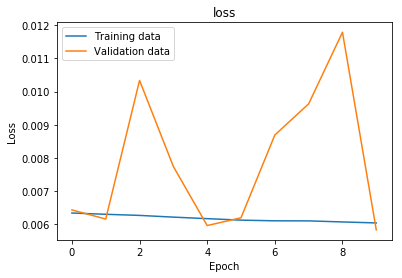

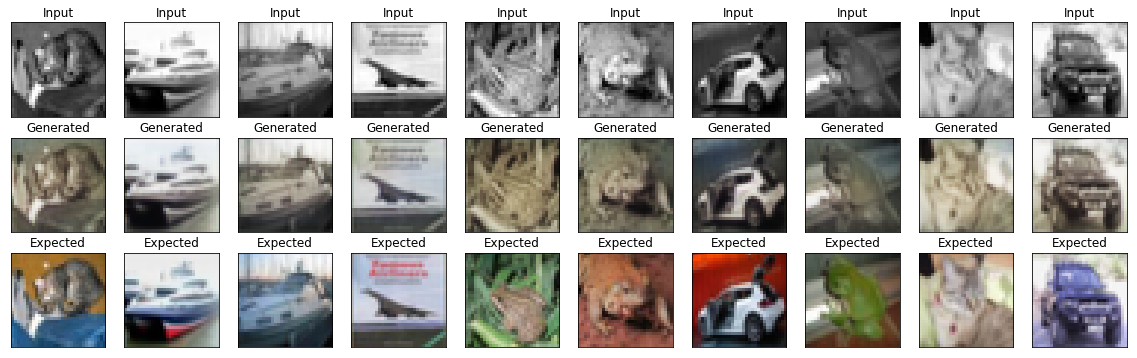

In [21]:
epochs=10
batch_size=256
n_repeat = 1

for _ in range(n_repeat):
    history = unet.fit(data.x_train_in, data.x_train_out,
                       epochs=epochs,
                       batch_size=batch_size,
                       shuffle=True,
                       validation_split=0.2)
    print('epochs : ' + str(_*epochs))
    unet.save_weights(full_path)
    print('File saved')

    plot_loss(history, 'loss')
    show_images(data, unet)

## Result

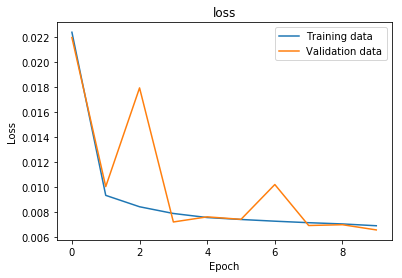

(10000, 3, 32, 32)
(10000, 32, 32, 3)


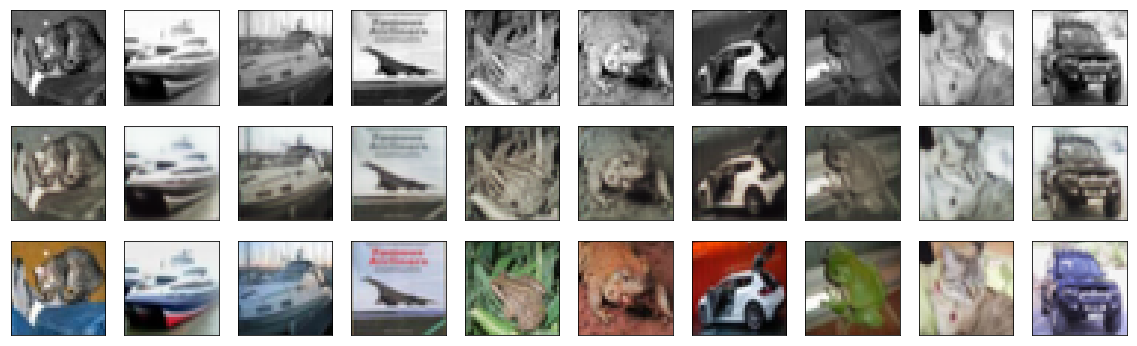

In [13]:
plot_loss(history, 'loss')
show_images(data,unet)